(985, 1008)


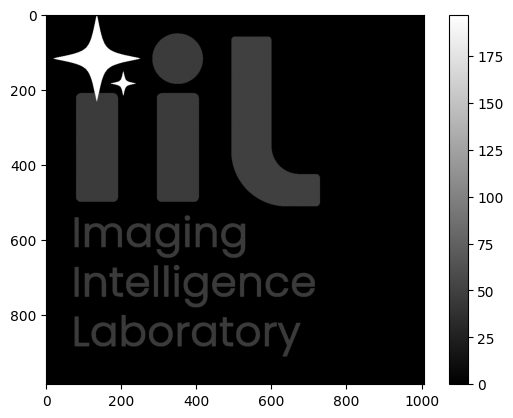

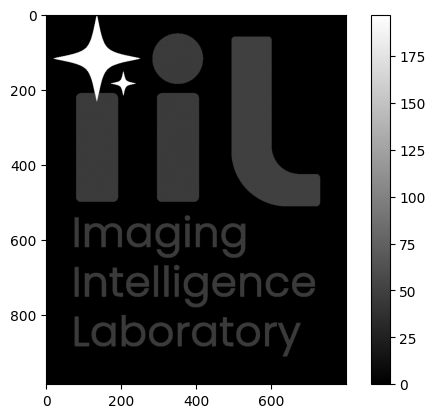

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

iil_logo_trans = cv.imread('./images/iil_logo_text_bottom.png',cv.IMREAD_GRAYSCALE)
plt.figure()
plt.imshow(iil_logo_trans,cmap='gray')
plt.colorbar()
print(iil_logo_trans.shape) #(985,1008)

iil_logo_cropped = iil_logo_trans[:,0:800] #(985,800)
plt.figure()
plt.imshow(iil_logo_cropped,cmap='gray')
plt.colorbar()



1000x1000으로 zero padding, 그리고 저장

(1000, 1000)
(1000, 1000)
(1000, 1000)
(1000, 1000)


True

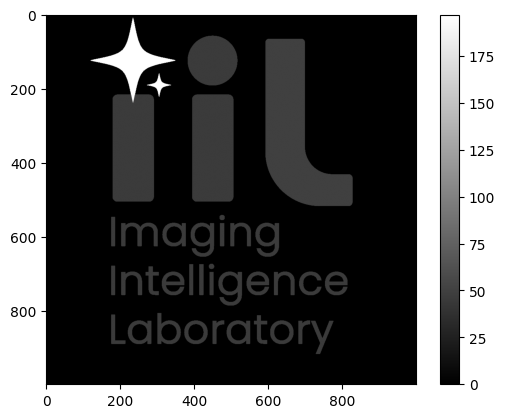

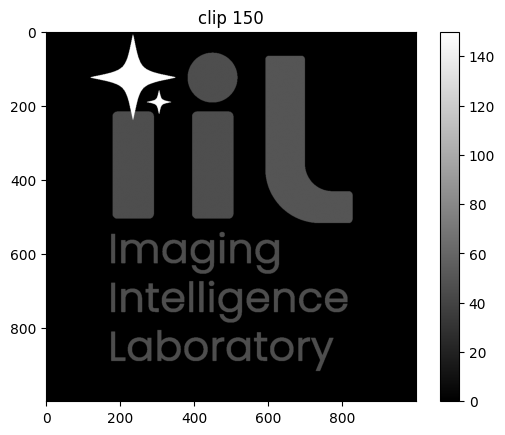

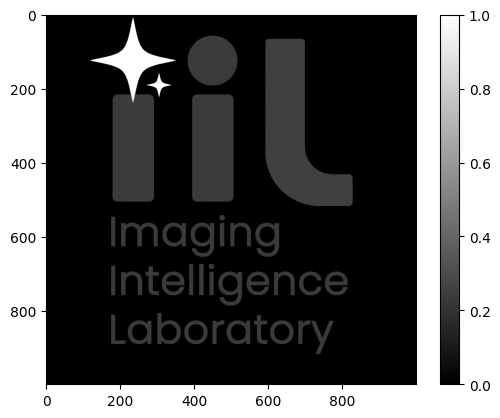

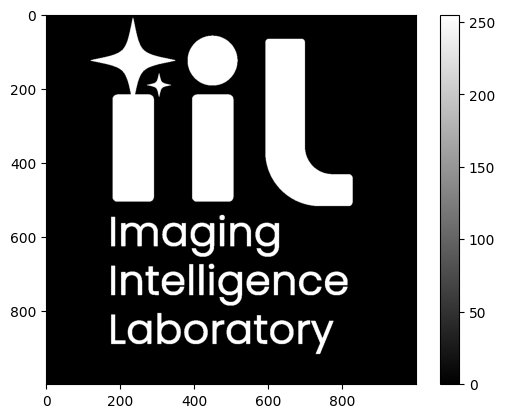

In [9]:
# 기존 이미지 크기
cropped = iil_logo_cropped
h, w = cropped.shape  # h=985, w=800

# 목표 크기
target_h, target_w = 1000, 1000

# 패딩 크기 계산
pad_top = (target_h - h) // 2
pad_bottom = target_h - h - pad_top
pad_left = (target_w - w) // 2
pad_right = target_w - w - pad_left

def normalize_minmax(img):
    img = img.astype(np.float32)
    min_val = img.min()
    max_val = img.max()
    norm = (img - min_val) / (max_val - min_val + 1e-8)  # 작은 값 추가로 0 나눗셈 방지
    return norm


# 제로 패딩 적용
padded = np.pad(cropped, ((pad_top, pad_bottom), (pad_left, pad_right)), mode='constant', constant_values=0)
padded_minmax = normalize_minmax(padded)
# 결과 확인
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(padded, cmap='gray')
plt.colorbar()
print(padded.shape)  # (1000, 1000)

plt.figure()
plt.imshow(np.clip(padded,0,150), cmap='gray')
plt.colorbar()
plt.title('clip 150')
print(padded.shape)

plt.figure()
plt.imshow(padded_minmax, cmap='gray')
plt.colorbar()
print(padded.shape)  # (1000, 1000)

binary = np.where(padded > 10, 255, 0).astype(np.uint8)
plt.figure()
plt.imshow(binary, cmap='gray')
plt.colorbar()
print(padded.shape)  # (1000, 1000)



# 이미지 저장
cv.imwrite('./images/iil_binary_padded_1000x1000.png', binary)

In [13]:
import torch
import torch.nn.functional as F
import torch.fft

iil_logo = cv.imread('./images/iil_logo_padded_1000x1000.png')
psf = cv.imread('./images/Voronoi1300_dist76px.png',cv.IMREAD_GRAYSCALE)
print(psf.shape)
psf_1000 = psf[:1000,:1000]
# cv.imwrite('./images/psf_1000x1000.png',psf_1000) # 저장완료.
psf_1000x1000 = cv.imread('./images/psf_1000x1000.png',cv.IMREAD_GRAYSCALE)
print(psf_1000x1000.shape)
# def convolve_rgb_raw_gen(psf_pad, scene_pad):
#     # scene_pad: (3, H, W), RGB 이미지
#     # psf_pad: (H, W), grayscale PSF

#     # PSF를 RGB 채널에 맞게 확장
#     psf_tensor = torch.tensor(psf_pad, dtype=torch.float32) / 255.0
#     psf_tensor = psf_tensor.unsqueeze(0).repeat(3, 1, 1)  # (3, H, W)

#     scene_tensor = torch.tensor(scene_pad, dtype=torch.float32).permute(2, 0, 1) / 255.0  # (3, H, W)

#     # FFT 연산
#     scene_fft = torch.fft.fftn(scene_tensor, dim=(-2, -1))
#     psf_fft = torch.fft.fftn(psf_tensor, dim=(-2, -1))

#     # Convolution in frequency domain
#     result_fft = scene_fft * psf_fft
#     result = torch.fft.ifftn(result_fft, dim=(-2, -1))
#     result = torch.fft.ifftshift(result, dim=(-2, -1))

#     # 결과를 실수값으로 변환하고 클리핑
#     result_abs = torch.abs(result)
#     result_img = (result_abs / result_abs.max() * 255.0).byte().permute(1, 2, 0).numpy()  # (H, W, 3)

#     return result_img
def convolve_rgb_raw_gen(psf_pad, scene_pad):
    # scene_pad: (H, W) or (H, W, C)
    # psf_pad: (H, W), grayscale PSF

    # scene_pad가 2D이면 채널 차원 추가 (1채널)
    if scene_pad.ndim == 2:
        scene_pad = scene_pad[:, :, np.newaxis]  # (H, W, 1)

    C = scene_pad.shape[2]  # 채널 수 감지

    # PSF를 채널 수에 맞게 확장
    psf_tensor = torch.tensor(psf_pad, dtype=torch.float32) / 255.0
    psf_tensor = psf_tensor.unsqueeze(0).repeat(C, 1, 1)  # (C, H, W)

    # scene_pad를 텐서로 변환하고 채널 앞으로 이동
    scene_tensor = torch.tensor(scene_pad, dtype=torch.float32).permute(2, 0, 1) / 255.0  # (C, H, W)

    # FFT 연산
    scene_fft = torch.fft.fftn(scene_tensor, dim=(-2, -1))
    psf_fft = torch.fft.fftn(psf_tensor, dim=(-2, -1))

    # 주파수 영역에서 곱셈
    result_fft = scene_fft * psf_fft
    result = torch.fft.ifftn(result_fft, dim=(-2, -1))
    result = torch.fft.ifftshift(result, dim=(-2, -1))

    # 결과를 실수값으로 변환하고 정규화
    result_abs = torch.abs(result)
    result_img = (result_abs / result_abs.max() * 255.0).byte().permute(1, 2, 0).numpy()  # (H, W, C)

    return result_img
print("binary.shape: ",iil_logo.shape)
raw_img = convolve_rgb_raw_gen(psf_1000x1000, binary)
print(raw_img.shape)
cv.imwrite('./images/raw_result_binary.png', raw_img)

(1299, 1299)
(1000, 1000)
binary.shape:  (1000, 1000, 3)
(1000, 1000, 1)


True

deconvolution

In [16]:
def img_pad(b, full_size):
    v_pad = int(np.ceil(abs(full_size[0] - b.shape[0]) // 2))
    h_pad = int(np.ceil(abs(full_size[1] - b.shape[1]) // 2))
    if b.ndim == 3:
        out = f.pad(b, (0, 0, h_pad, h_pad, v_pad, v_pad))
        return out[:full_size[0], :full_size[1], :]
    else:
        out = f.pad(b, (h_pad, h_pad, v_pad, v_pad))
        return out[:full_size[0], :full_size[1]]
    
# size_1 = (2000,2000)
# img_padded = img_pad(A,size_1)

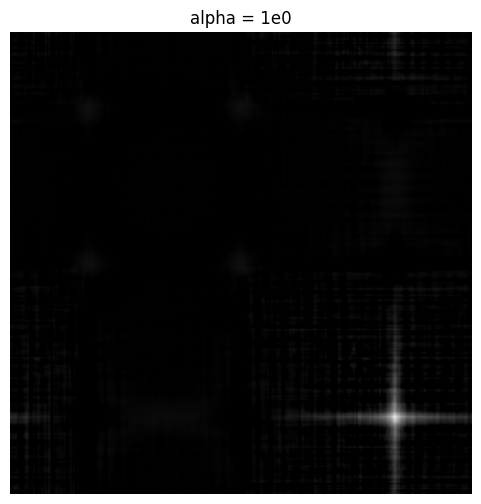

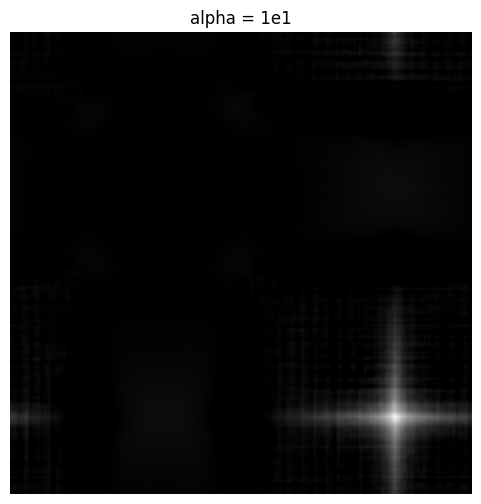

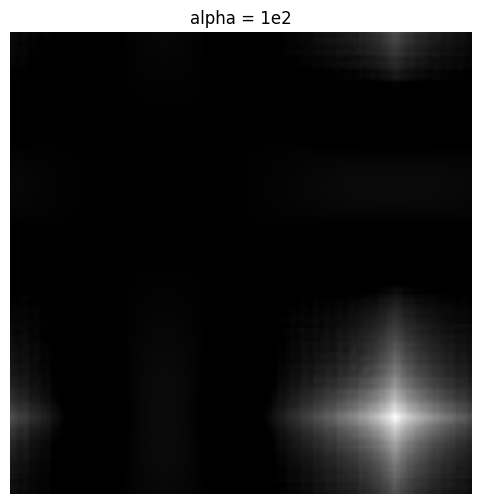

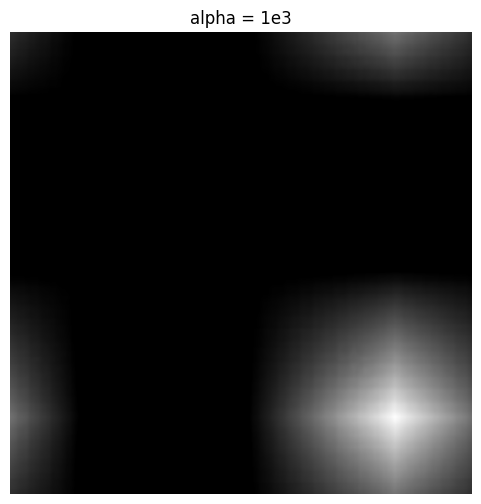

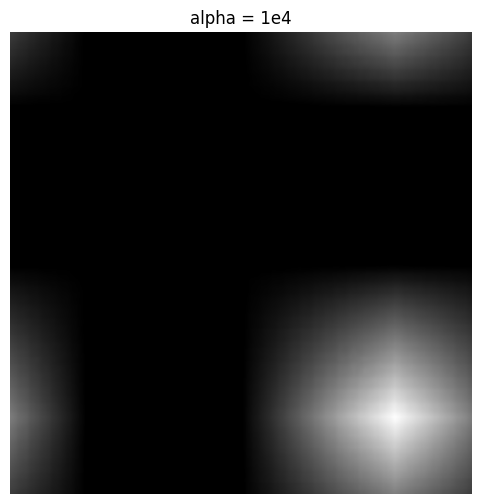

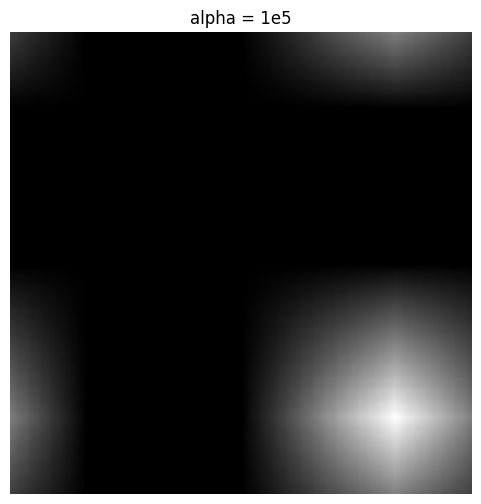

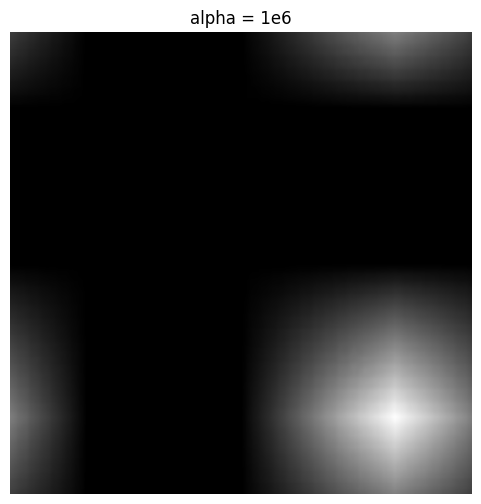

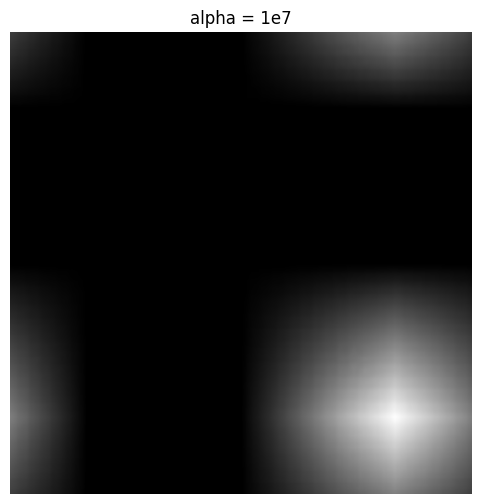

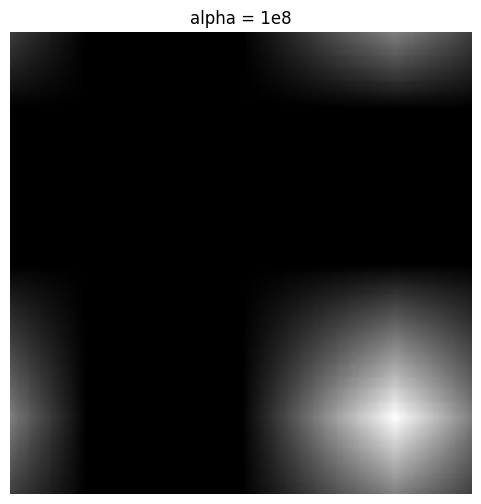

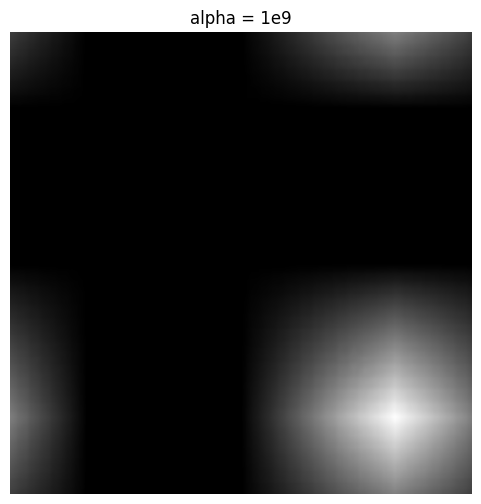

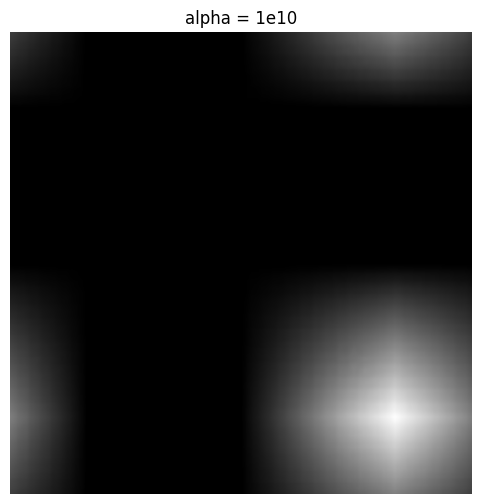

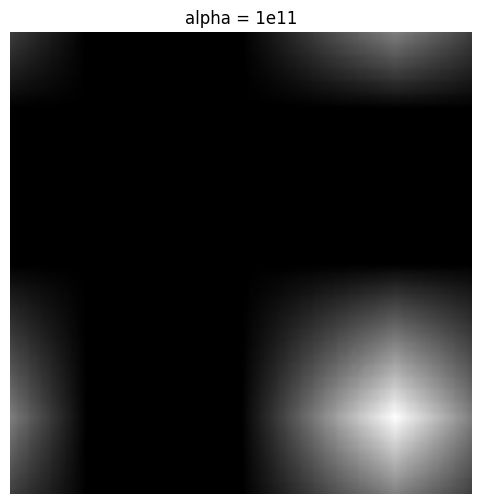

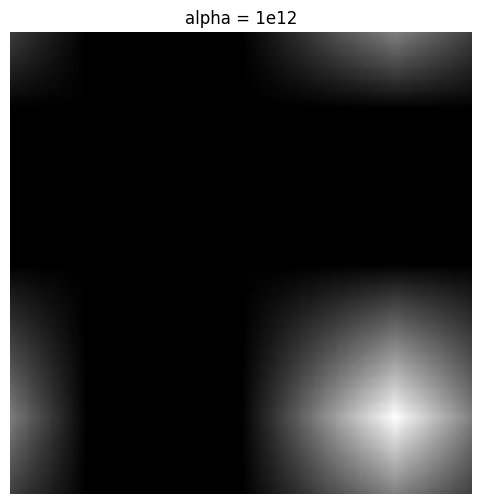

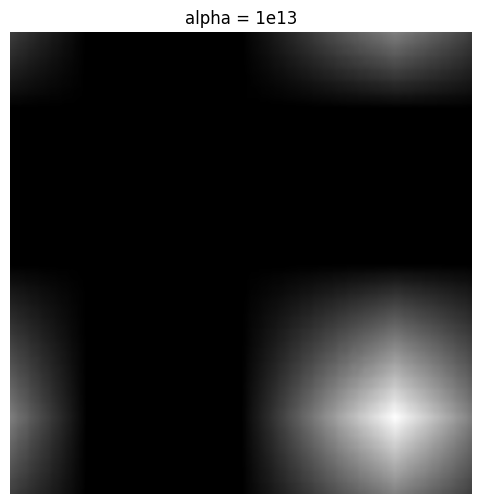

In [21]:
import torch
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as f

def deconv(psf_padded, raw_padded, alpha=1e2):
    psf_padded = psf_padded / np.linalg.norm(psf_padded)
    raw_padded = raw_padded / 255

    psf_padded = torch.tensor(psf_padded,device='cuda').permute(2,0,1).unsqueeze(0)
    raw_padded = torch.tensor(raw_padded,device='cuda').permute(2,0,1).unsqueeze(0)

    raw_padded = img_pad(raw_padded,(2000,2000))


    raw_fft = torch.fft.rfft2(raw_padded, dim=(-2, -1))  # Shape: (B, C, H_freq, W_freq)
    psf_fft = torch.fft.rfft2(psf_padded, s=(raw_padded.size(-2), raw_padded.size(-1)), dim=(-2, -1))  # Shape: (B, C, H_freq, W_freq)

    wiener_filter = psf_fft.conj() / (psf_fft.abs()**2 + alpha)
    out_fft = raw_fft * wiener_filter  # (k, B, C, H, W//2+1)

    out_spatial = torch.fft.irfft2(out_fft, dim=(-2, -1))
    out_spatial = torch.fft.ifftshift(out_spatial, dim=(-2, -1))

    out = out_spatial[0].permute(1,2,0)
    
    out = out / out.max()
    # out = out / (out.mean())
    # out = (out - out.min()) / (out.max() - out.min())
    out[out<0] = 0
    out = out.cpu().detach().numpy()
    out = np.uint8(out * 255)
    out = cv2.cvtColor(out, cv2.COLOR_BGR2RGB)
    # out = np.rot90(out,2)
    # out = crop_center(out)
    return out

def crop_center(img):
    H,W = img.shape[:2]
    yc = int(H/2)
    xc = int(W/2)
    yc = 1600-400
    xc = 2350
    d = 700
    return img[yc-d:yc+d,xc-d:xc+d,:]

# lists = [13.6,14.6,15.6]
# lists_img = [1,2]

result_path = "./deconv_result/"
if not os.path.exists(result_path):
    os.makedirs(result_path)

alphas = [10**i for i in range(1, 15)]

psf_padded = cv2.imread("./images/psf_1000x1000.png")
raw_padded = cv2.imread("./images/raw_result.png")

for i, alpha in enumerate(alphas):
    out = deconv(psf_padded, raw_padded, alpha=alpha)

    # 시각화
    plt.figure(figsize=(10, 6))
    plt.imshow(out)
    plt.axis('off')
    plt.title(f'alpha = 1e{i}')
    plt.show()
# out = deconv(psf_padded, raw_padded, alpha=(1e1)/2)
# plt.figure(figsize=(10,6))
# plt.imshow(out)
# # cv2.imwrite(f"{result_path}250711_deconv_{i}.png",cv2.cvtColor(out, cv2.COLOR_BGR2RGB))
# plt.axis('off')
# plt.show()
# print("raw image : 07.0 mm, PSF : ",psf_i,"mm")

In [6]:
from scipy.io import loadmat, savemat
import numpy as np
import cv2  # OpenCV 사용

# 1. .mat 파일 불러오기
matfile = loadmat("/home/hotdog/files_251026/image_stack_cropped_2nd_251024.mat")
image_stack = matfile['images']  # shape: (101, 1300, 1300)

# 2. 10개 간격으로 슬라이스 (0, 10, ..., 100)
selected_images = image_stack[11:32:1]  # shape: (21, 1300, 1300)

# 3. 각 이미지 리사이즈 (512x512)
resized_images = np.array([
    cv2.resize(img, (512, 512), interpolation=cv2.INTER_AREA)
    for img in selected_images
])

# 4. 저장
savemat("/home/hotdog/files_251026/image_stack_selected_resized_512_060_080.mat", {'images': resized_images})

In [8]:
matfile = loadmat("/home/hotdog/files_251026/image_stack_selected_resized_512_060_080.mat")
image_stack_gg = matfile['images'] 

print("Shape: ", image_stack_gg.shape)

Shape:  (21, 512, 512)
